In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [6]:
def load_data():
    
    # CMIP data       
    cmip_sst = torch.load("process_data/cmip_sst_data.pt")  ## 56156, 12, 24, 72
    cmip_t300 = torch.load("process_data/cmip_t300_data.pt")
    cmip_ua = torch.load("process_data/cmip_ua_data.pt")
    cmip_va = torch.load("process_data/cmip_va_data.pt")
    cmip_label = torch.load("process_data/cmip_label.pt")
    
    soda_sst = torch.load("process_data/soda_sst_data.pt")  # (1189, 12, 24, 72)
    soda_t300 = torch.load("process_data/soda_t300_data.pt")
    soda_ua = torch.load("process_data/soda_ua_data.pt")
    soda_va = torch.load("process_data/soda_va_data.pt")
    soda_label = torch.load("process_data/soda_label.pt")

    dict_cmip = {
        'sst':cmip_sst,
        't300':cmip_t300,
        'ua':cmip_ua,
        'va': cmip_va,
        'label': cmip_label}
    dict_soda = {
        'sst':soda_sst,
        't300':soda_t300,
        'ua':soda_ua,
        'va': soda_va,
        'label': soda_label}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [50000, 5388])
    train_2, valid_2 = random_split(soda_dataset, [1000, 189])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2
    valid_dataset = valid_1
    valid_dataset_2 = valid_2
    
    print('Train samples: {}, Valid1 samples: {}, Valid2 samples: {}'.format(len(train_dataset), len(valid_dataset), len(valid_dataset_2)))
    
    return train_dataset, valid_dataset, valid_dataset_2

In [7]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset, valid_dataset_2 = load_data()      
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size=32, shuffle=False)

Train samples: 54000, Valid1 samples: 5388, Valid2 samples: 189


In [8]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    score_epoch_2 = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    best_score = score
    
    y_true_2, y_pred_2 = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred_2.append(preds.cpu().detach().numpy())
        y_true_2.append(label.cpu().detach().numpy())

    y_true_2 = np.concatenate(y_true_2, axis=0)
    y_pred_2 = np.concatenate(y_pred_2, axis=0)
    x_month = np.arange(24)
    score_2 = eval_score(y_true_2, y_pred_2)
    print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):   
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%50 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds.cpu().detach().numpy())
            y_true.append(label.cpu().detach().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        
        y_true_2, y_pred_2 = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred_2.append(preds.cpu().detach().numpy())
            y_true_2.append(label.cpu().detach().numpy())

        y_true_2 = np.concatenate(y_true_2, axis=0)
        y_pred_2 = np.concatenate(y_pred_2, axis=0)
        x_month = np.arange(24)
        score_2 = eval_score(y_true_2, y_pred_2)
        score_epoch_2.append(score_2)
        print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(10):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        j = 0
        for i in range(10, 23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true_2[j],color='red')
            plt.plot(x_month, y_pred_2[j],color='blue')
            j += 1
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.plot(np.arange(len(score_epoch)),score_epoch_2)
        plt.tight_layout()
        plt.show()
        
    max_score = max(score_epoch)
    max_epoch = score_epoch.index(max_score) + 1
    print("max score: {} at eopch {}".format(max_score, max_epoch))
    max_score_2 = max(score_epoch_2)
    max_epoch_2 = score_epoch_2.index(max_score_2) + 1
    print("max score 2: {} at eopch {}".format(max_score_2, max_epoch_2))

In [18]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 64))
        self.linear = nn.Linear(64, 24)

    def forward(self, sst, t300, ua, va):
        sst = self.conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
        t300 = self.conv2(t300)
        ua = self.conv3(ua)
        va = self.conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
        x = self.batch_norm(x)
        x = self.avgpool(x).squeeze(dim=-2)
        x = self.linear(x)
        return x

In [19]:
'''
(1, 128): max score: 44.37983631523829 at eopch 49; max score 2: 5.373897295704463 at eopch 20
(1, 64):  max score: 38.86314433249353 at eopch 48, max score 2: 12.67324381162318 at eopch 50



'''

'\n(1, 128): max score: 44.37983631523829 at eopch 49; max score 2: 5.373897295704463 at eopch 20\n(1, 64):  max score: 38.86314433249353 at eopch 48, max score 2: 12.67324381162318 at eopch 50\n\n\n\n'

In [20]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

gpu_ids = [i for i in range(int(torch.cuda.device_count()))]
model = torch.nn.DataParallel(model.to("cuda:0"), device_ids=gpu_ids)
loss_fn = loss_fn.to(device)

In [21]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

DataParallel : all params: 0.020064M


In [22]:
model

DataParallel(
  (module): CNN_Model(
    (conv1): Sequential(
      (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
    )
    (conv2): Sequential(
      (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
    )
    (conv3): Sequential(
      (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
    )
    (conv4): Sequential(
      (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
    )
    (batch_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 64))
    (linear): Linear(in_features=64, out_features=24, bias=True)
  )
)

acskill_socre:0.18856255289060556, rmse_score:20.893150297131708
acskill_socre:5.405160364056512, rmse_score:18.722135774770084
Epoch: 0, Valid Score: -20.704587744241103, Valid Score 2: -13.316975410713573

Step: 0, Train Loss: 0.7012786865234375
Step: 50, Train Loss: 0.715575098991394
Step: 100, Train Loss: 0.6431736350059509
Step: 150, Train Loss: 0.5983150005340576
Step: 200, Train Loss: 0.6174159646034241
Step: 250, Train Loss: 0.6224281787872314
Step: 300, Train Loss: 0.6582226753234863
Step: 350, Train Loss: 0.6563332080841064
Step: 400, Train Loss: 0.5745885372161865
Epoch: 1, Train loss: 0.6454779551633726
acskill_socre:41.45759691944742, rmse_score:18.1209948784017
acskill_socre:16.905731507425592, rmse_score:18.46324465962041
Epoch: 1, Valid Score: 23.33660204104572, Valid Score 2: -1.5575131521948187

Model saved successfully


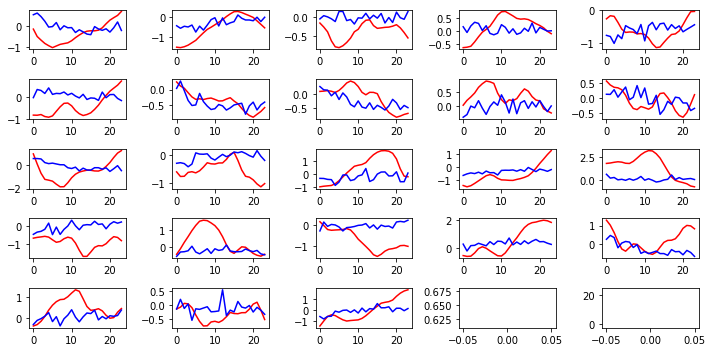

Step: 0, Train Loss: 0.6369752287864685
Step: 50, Train Loss: 0.5423463582992554
Step: 100, Train Loss: 0.5257974863052368
Step: 150, Train Loss: 0.5354032516479492
Step: 200, Train Loss: 0.5535570979118347
Step: 250, Train Loss: 0.6322579383850098
Step: 300, Train Loss: 0.438274085521698
Step: 350, Train Loss: 0.5938997268676758
Step: 400, Train Loss: 0.5656826496124268
Epoch: 2, Train loss: 0.548170148478865
acskill_socre:47.30138300779261, rmse_score:17.21454396499085
acskill_socre:23.678679453247703, rmse_score:17.684934242312732
Epoch: 2, Valid Score: 30.08683904280176, Valid Score 2: 5.993745210934971

Model saved successfully


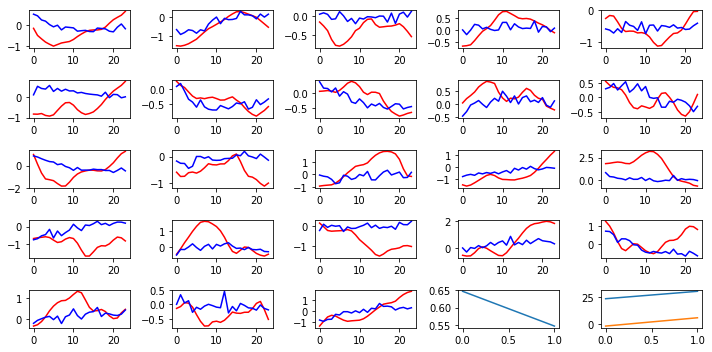

Step: 0, Train Loss: 0.628502368927002
Step: 50, Train Loss: 0.5131934881210327
Step: 100, Train Loss: 0.5150700807571411
Step: 150, Train Loss: 0.484701007604599
Step: 200, Train Loss: 0.4436036944389343
Step: 250, Train Loss: 0.5394377112388611
Step: 300, Train Loss: 0.4772563874721527
Step: 350, Train Loss: 0.47360074520111084
Step: 400, Train Loss: 0.5068840384483337
Epoch: 3, Train loss: 0.5141030668647368
acskill_socre:49.93018685215395, rmse_score:16.763153838144472
acskill_socre:26.22579376816103, rmse_score:17.37528251625337
Epoch: 3, Valid Score: 33.167033014009476, Valid Score 2: 8.850511251907658

Model saved successfully


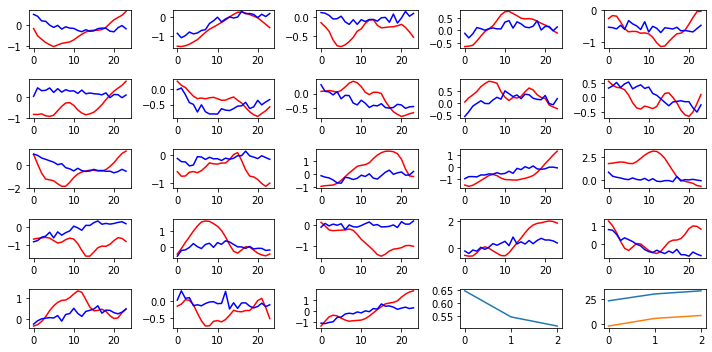

Step: 0, Train Loss: 0.5039325952529907
Step: 50, Train Loss: 0.4999556541442871
Step: 100, Train Loss: 0.4638753831386566
Step: 150, Train Loss: 0.5327661037445068
Step: 200, Train Loss: 0.47287222743034363
Step: 250, Train Loss: 0.4734015464782715
Step: 300, Train Loss: 0.5862505435943604
Step: 350, Train Loss: 0.4960373640060425
Step: 400, Train Loss: 0.4528772830963135
Epoch: 4, Train loss: 0.4963877874810549
acskill_socre:51.38987415923914, rmse_score:16.50275184500852
acskill_socre:27.329242163553765, rmse_score:17.24592039291512
Epoch: 4, Valid Score: 34.88712231423062, Valid Score 2: 10.083321770638644

Model saved successfully


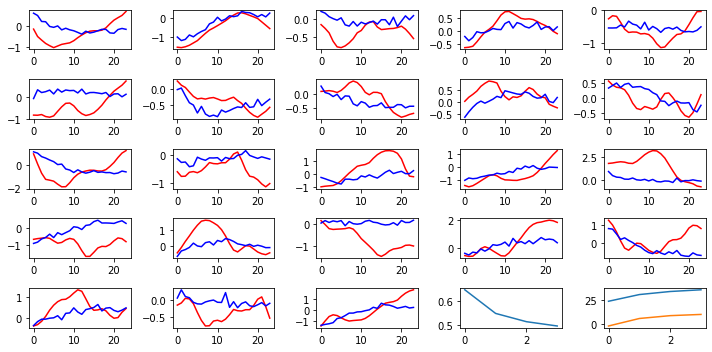

Step: 0, Train Loss: 0.47245439887046814
Step: 50, Train Loss: 0.4743086099624634
Step: 100, Train Loss: 0.626035749912262
Step: 150, Train Loss: 0.478727787733078
Step: 200, Train Loss: 0.5726076364517212
Step: 250, Train Loss: 0.43815574049949646
Step: 300, Train Loss: 0.48161572217941284
Step: 350, Train Loss: 0.44369086623191833
Step: 400, Train Loss: 0.5386856198310852
Epoch: 5, Train loss: 0.4856239041728431
acskill_socre:52.397791034069385, rmse_score:16.31992171600774
acskill_socre:28.23729437702305, rmse_score:17.127013445081065
Epoch: 5, Valid Score: 36.077869318061644, Valid Score 2: 11.110280931941986

Model saved successfully


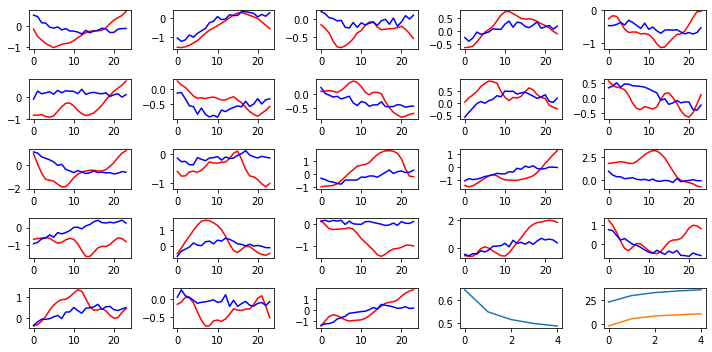

Step: 0, Train Loss: 0.4822642207145691
Step: 50, Train Loss: 0.464657723903656
Step: 100, Train Loss: 0.40483158826828003
Step: 150, Train Loss: 0.43570399284362793
Step: 200, Train Loss: 0.43595051765441895
Step: 250, Train Loss: 0.5498608350753784
Step: 300, Train Loss: 0.3982389569282532
Step: 350, Train Loss: 0.5696871280670166
Step: 400, Train Loss: 0.5212392210960388
Epoch: 6, Train loss: 0.4784499564300781
acskill_socre:53.10771650453496, rmse_score:16.197515818796006
acskill_socre:28.204844642626405, rmse_score:17.12052403862123
Epoch: 6, Valid Score: 36.91020068573896, Valid Score 2: 11.084320604005175

Model saved successfully


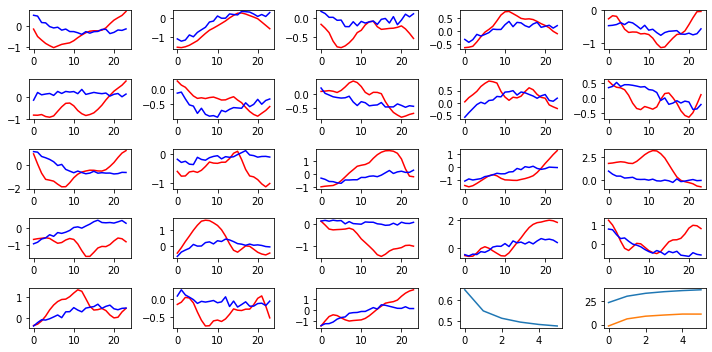

Step: 0, Train Loss: 0.5551763772964478
Step: 50, Train Loss: 0.46503275632858276
Step: 100, Train Loss: 0.5101630687713623
Step: 150, Train Loss: 0.4983556270599365
Step: 200, Train Loss: 0.45289045572280884
Step: 250, Train Loss: 0.4300449788570404
Step: 300, Train Loss: 0.39848750829696655
Step: 350, Train Loss: 0.6224633455276489
Step: 400, Train Loss: 0.4779779314994812
Epoch: 7, Train loss: 0.4731613097456394
acskill_socre:53.70596752156551, rmse_score:16.103353233203936
acskill_socre:28.675419330970094, rmse_score:17.106303532605306
Epoch: 7, Valid Score: 37.60261428836158, Valid Score 2: 11.569115798364788

Model saved successfully


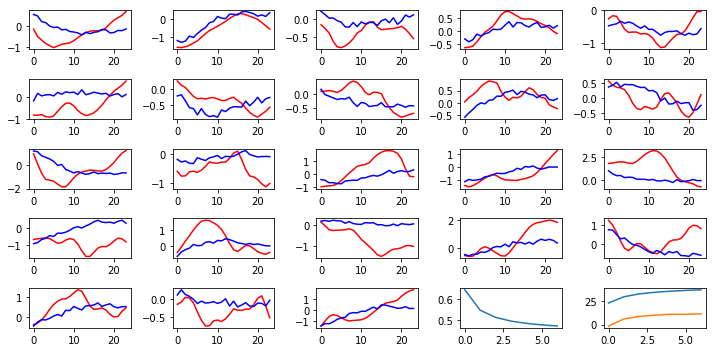

Step: 0, Train Loss: 0.4941902160644531
Step: 50, Train Loss: 0.5046830773353577
Step: 100, Train Loss: 0.47119003534317017
Step: 150, Train Loss: 0.4381105303764343
Step: 200, Train Loss: 0.44063901901245117
Step: 250, Train Loss: 0.502546489238739
Step: 300, Train Loss: 0.45279449224472046
Step: 350, Train Loss: 0.3970450162887573
Step: 400, Train Loss: 0.49692291021347046
Epoch: 8, Train loss: 0.468971175040114
acskill_socre:54.19354571351734, rmse_score:16.031417965625796
acskill_socre:28.30570503710326, rmse_score:17.081722292488944
Epoch: 8, Valid Score: 38.162127747891546, Valid Score 2: 11.223982744614315

Model saved successfully


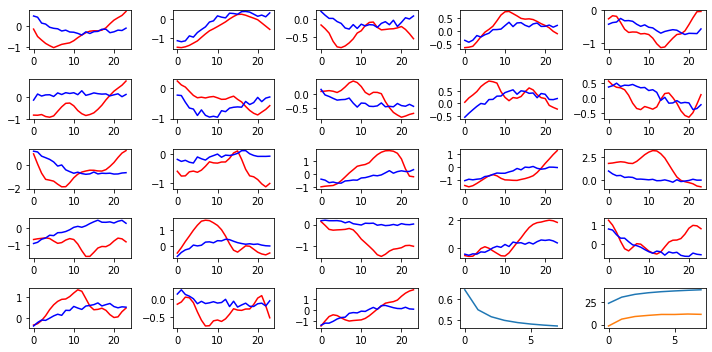

Step: 0, Train Loss: 0.4707091748714447
Step: 50, Train Loss: 0.5016026496887207
Step: 100, Train Loss: 0.44757184386253357
Step: 150, Train Loss: 0.37567925453186035
Step: 200, Train Loss: 0.4743278920650482
Step: 250, Train Loss: 0.545069694519043
Step: 300, Train Loss: 0.3914484679698944
Step: 350, Train Loss: 0.4532153606414795
Step: 400, Train Loss: 0.4345182776451111
Epoch: 9, Train loss: 0.4654223918914795
acskill_socre:54.514748406708634, rmse_score:15.970448556708316
acskill_socre:28.204431039358457, rmse_score:17.071885294944458
Epoch: 9, Valid Score: 38.544299850000314, Valid Score 2: 11.132545744414

Model saved successfully


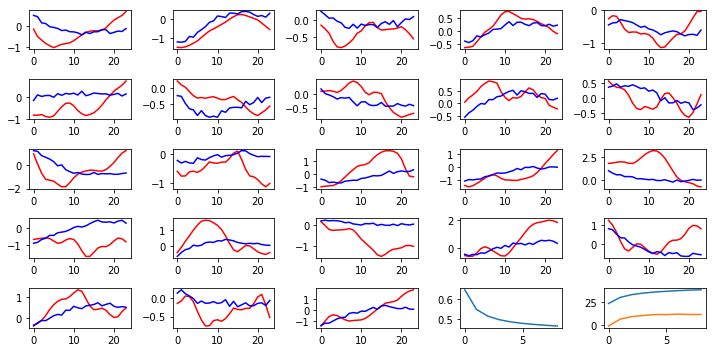

Step: 0, Train Loss: 0.4659390449523926
Step: 50, Train Loss: 0.580663800239563
Step: 100, Train Loss: 0.4755539894104004
Step: 150, Train Loss: 0.5147568583488464
Step: 200, Train Loss: 0.47672125697135925
Step: 250, Train Loss: 0.5084345936775208
Step: 300, Train Loss: 0.47634607553482056
Step: 350, Train Loss: 0.42694205045700073
Step: 400, Train Loss: 0.4519747495651245
Epoch: 10, Train loss: 0.4624191345338008
acskill_socre:54.91589870348035, rmse_score:15.908191027515128
acskill_socre:28.676383822914303, rmse_score:17.063448251042246
Epoch: 10, Valid Score: 39.00770767596522, Valid Score 2: 11.612935571872057

Model saved successfully


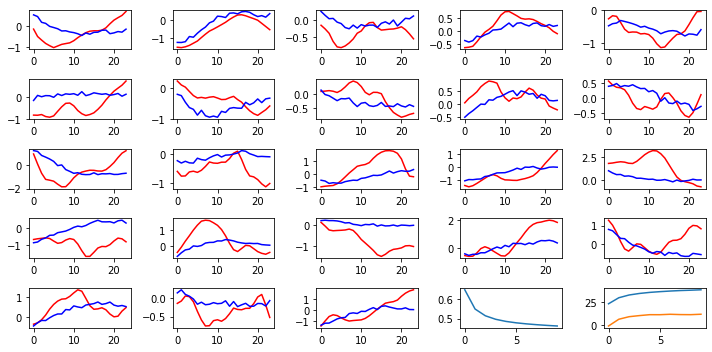

Step: 0, Train Loss: 0.4640008807182312
Step: 50, Train Loss: 0.43971937894821167
Step: 100, Train Loss: 0.5265023112297058
Step: 150, Train Loss: 0.5608950853347778
Step: 200, Train Loss: 0.4514208734035492
Step: 250, Train Loss: 0.42225050926208496
Step: 300, Train Loss: 0.42282742261886597
Step: 350, Train Loss: 0.425810307264328
Step: 400, Train Loss: 0.4306008815765381
Epoch: 11, Train loss: 0.45968089383360333
acskill_socre:55.255509733818386, rmse_score:15.867545281487933
acskill_socre:28.715265955636212, rmse_score:17.040959948903698
Epoch: 11, Valid Score: 39.38796445233045, Valid Score 2: 11.674306006732515

Model saved successfully


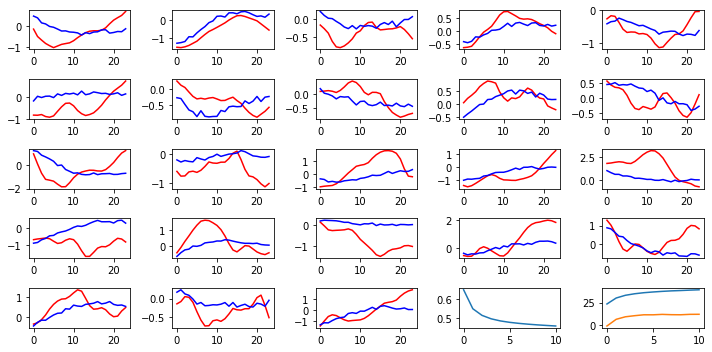

Step: 0, Train Loss: 0.46413904428482056
Step: 50, Train Loss: 0.4271639287471771
Step: 100, Train Loss: 0.4703061580657959
Step: 150, Train Loss: 0.42068013548851013
Step: 200, Train Loss: 0.38071221113204956
Step: 250, Train Loss: 0.434130996465683
Step: 300, Train Loss: 0.4227182865142822
Step: 350, Train Loss: 0.5163442492485046
Step: 400, Train Loss: 0.4800202548503876
Epoch: 12, Train loss: 0.45738541366647206
acskill_socre:55.47823775965972, rmse_score:15.816752474796449
acskill_socre:29.38922421285799, rmse_score:16.990952123987817
Epoch: 12, Valid Score: 39.661485284863275, Valid Score 2: 12.398272088870172

Model saved successfully


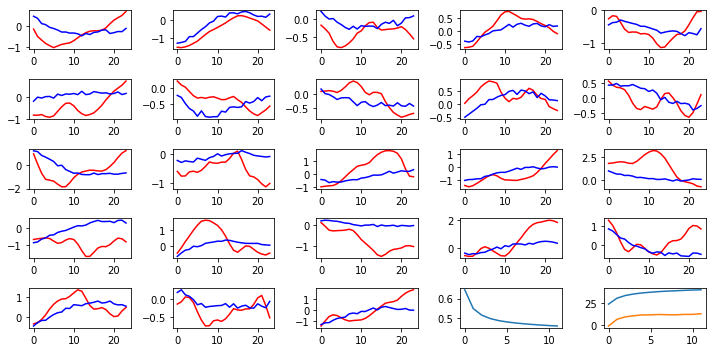

Step: 0, Train Loss: 0.4737280309200287
Step: 50, Train Loss: 0.4066198766231537
Step: 100, Train Loss: 0.5213119387626648
Step: 150, Train Loss: 0.5100498199462891
Step: 200, Train Loss: 0.40768593549728394
Step: 250, Train Loss: 0.507487416267395
Step: 300, Train Loss: 0.4519636332988739
Step: 350, Train Loss: 0.4956284463405609
Step: 400, Train Loss: 0.456209659576416
Epoch: 13, Train loss: 0.45527594575384783
acskill_socre:55.880871062225864, rmse_score:15.775488613539979
acskill_socre:29.52592726034003, rmse_score:17.031896391427455
Epoch: 13, Valid Score: 40.10538244868589, Valid Score 2: 12.494030868912574

Model saved successfully


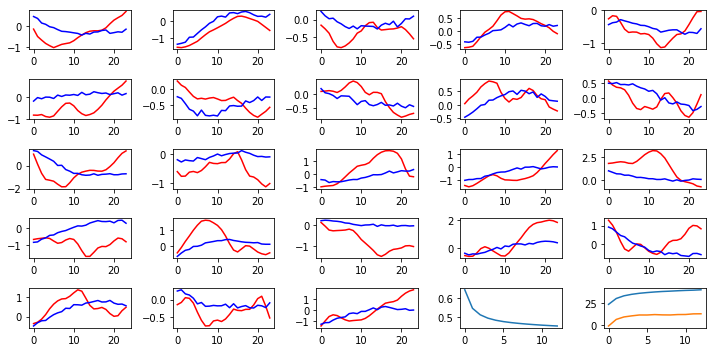

Step: 0, Train Loss: 0.5125657320022583
Step: 50, Train Loss: 0.42810070514678955
Step: 100, Train Loss: 0.543610692024231
Step: 150, Train Loss: 0.5304877758026123
Step: 200, Train Loss: 0.4019487798213959
Step: 250, Train Loss: 0.5787114500999451
Step: 300, Train Loss: 0.4434887766838074
Step: 350, Train Loss: 0.3570939004421234
Step: 400, Train Loss: 0.4999256134033203
Epoch: 14, Train loss: 0.45338901827968126
acskill_socre:56.062671070006516, rmse_score:15.732544916056968
acskill_socre:29.249347129884598, rmse_score:17.023300894540807
Epoch: 14, Valid Score: 40.33012615394955, Valid Score 2: 12.22604623534379

Model saved successfully


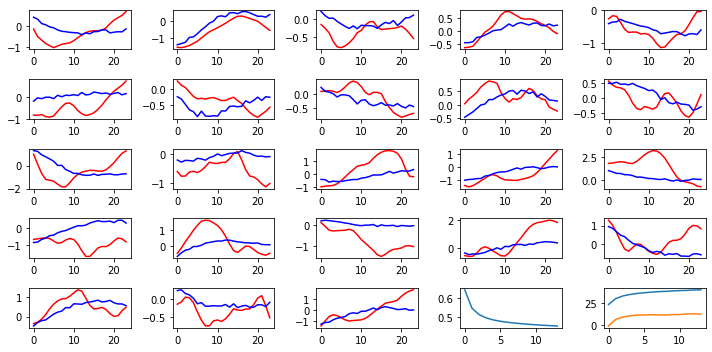

Step: 0, Train Loss: 0.43421798944473267
Step: 50, Train Loss: 0.4838607907295227
Step: 100, Train Loss: 0.46852192282676697
Step: 150, Train Loss: 0.4046286344528198
Step: 200, Train Loss: 0.500974178314209
Step: 250, Train Loss: 0.47231268882751465
Step: 300, Train Loss: 0.45360252261161804
Step: 350, Train Loss: 0.4397834241390228
Step: 400, Train Loss: 0.4240313470363617
Epoch: 15, Train loss: 0.4516186625189126
acskill_socre:56.20219455629136, rmse_score:15.704952314820606
acskill_socre:28.866786749993896, rmse_score:17.002000568901156
Epoch: 15, Valid Score: 40.49724224147076, Valid Score 2: 11.86478618109274

Model saved successfully


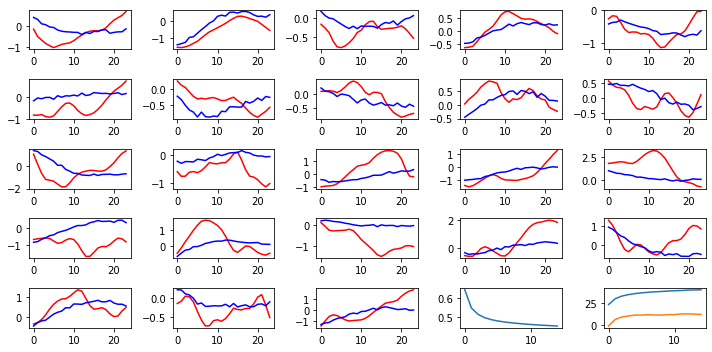

Step: 0, Train Loss: 0.46510180830955505
Step: 50, Train Loss: 0.5068455934524536
Step: 100, Train Loss: 0.43814000487327576
Step: 150, Train Loss: 0.46535229682922363
Step: 200, Train Loss: 0.52161705493927
Step: 250, Train Loss: 0.3830820918083191
Step: 300, Train Loss: 0.438757985830307
Step: 350, Train Loss: 0.5036088824272156
Step: 400, Train Loss: 0.41584867238998413
Epoch: 16, Train loss: 0.4499430695981211
acskill_socre:56.41669278765572, rmse_score:15.68052565082962
acskill_socre:28.39278380833322, rmse_score:17.05056790390309
Epoch: 16, Valid Score: 40.7361671368261, Valid Score 2: 11.34221590443013

Model saved successfully


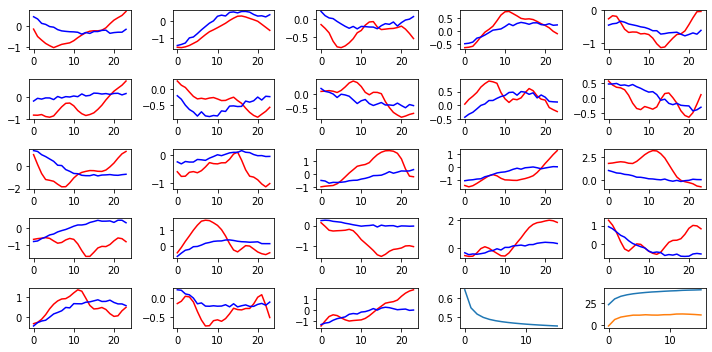

Step: 0, Train Loss: 0.5186694860458374
Step: 50, Train Loss: 0.5268587470054626
Step: 100, Train Loss: 0.4249347150325775
Step: 150, Train Loss: 0.4960005283355713
Step: 200, Train Loss: 0.5051061511039734
Step: 250, Train Loss: 0.4112488031387329
Step: 300, Train Loss: 0.4239513874053955
Step: 350, Train Loss: 0.4485440254211426
Step: 400, Train Loss: 0.3971174359321594
Epoch: 17, Train loss: 0.44849043399519267
acskill_socre:56.599307582555106, rmse_score:15.651367413695095
acskill_socre:28.4728092455689, rmse_score:17.03636817790213
Epoch: 17, Valid Score: 40.947940168860015, Valid Score 2: 11.43644106766677

Model saved successfully


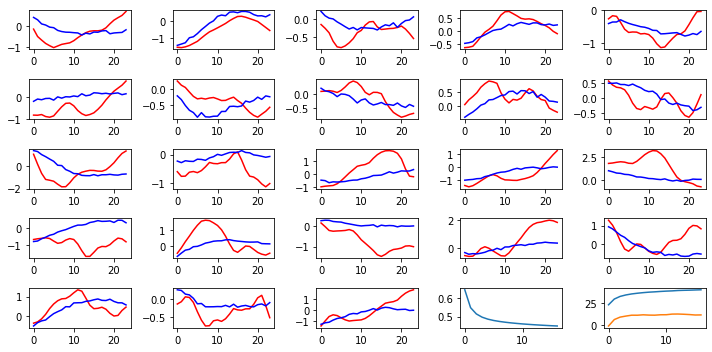

Step: 0, Train Loss: 0.5274348258972168
Step: 50, Train Loss: 0.4446658492088318
Step: 100, Train Loss: 0.46169257164001465
Step: 150, Train Loss: 0.5028949975967407
Step: 200, Train Loss: 0.40647363662719727
Step: 250, Train Loss: 0.42873138189315796
Step: 300, Train Loss: 0.45044374465942383
Step: 350, Train Loss: 0.4379898011684418
Step: 400, Train Loss: 0.46059930324554443
Epoch: 18, Train loss: 0.4470243151718971
acskill_socre:56.7806320943414, rmse_score:15.62647008378365
acskill_socre:29.17048013387025, rmse_score:16.968029464476185
Epoch: 18, Valid Score: 41.15416201055775, Valid Score 2: 12.202450669394064

Model saved successfully


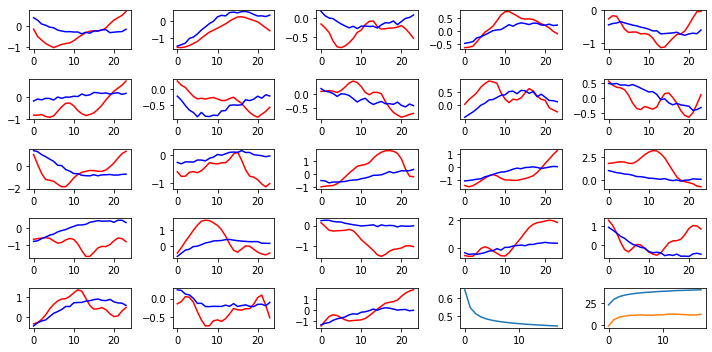

Step: 0, Train Loss: 0.45815563201904297
Step: 50, Train Loss: 0.4066983163356781
Step: 100, Train Loss: 0.49724096059799194
Step: 150, Train Loss: 0.4266526699066162
Step: 200, Train Loss: 0.5280578136444092
Step: 250, Train Loss: 0.4423942565917969
Step: 300, Train Loss: 0.4518584907054901
Step: 350, Train Loss: 0.4267563819885254
Step: 400, Train Loss: 0.3910714089870453
Epoch: 19, Train loss: 0.4458332401457556
acskill_socre:56.888111005763456, rmse_score:15.602160868261613
acskill_socre:28.509510012748315, rmse_score:17.032476509956567
Epoch: 19, Valid Score: 41.28595013750184, Valid Score 2: 11.477033502791748

Model saved successfully


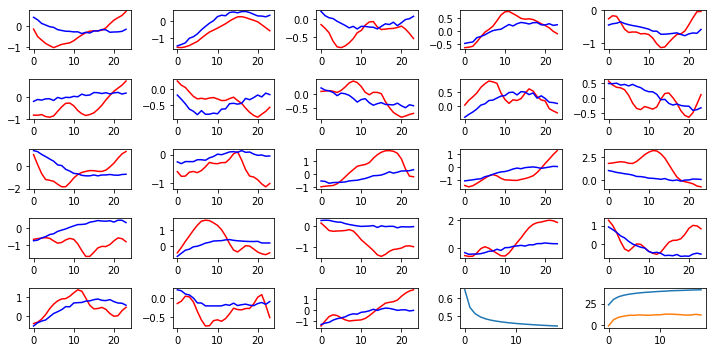

Step: 0, Train Loss: 0.4307747781276703
Step: 50, Train Loss: 0.4265645444393158
Step: 100, Train Loss: 0.4602460563182831
Step: 150, Train Loss: 0.517012894153595
Step: 200, Train Loss: 0.44261735677719116
Step: 250, Train Loss: 0.4766748547554016
Step: 300, Train Loss: 0.4269314706325531
Step: 350, Train Loss: 0.4220341145992279
Step: 400, Train Loss: 0.4299285411834717
Epoch: 20, Train loss: 0.4446762820696944
acskill_socre:57.00799094657166, rmse_score:15.575923340503449
acskill_socre:28.913793297782767, rmse_score:17.021581417083173
Epoch: 20, Valid Score: 41.43206760606821, Valid Score 2: 11.892211880699595

Model saved successfully


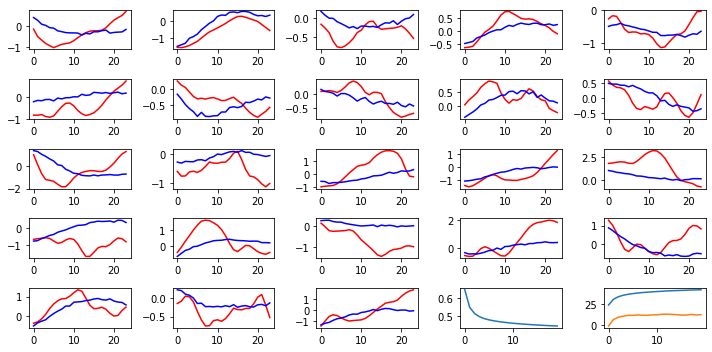

Step: 0, Train Loss: 0.4826205372810364
Step: 50, Train Loss: 0.4450060725212097
Step: 100, Train Loss: 0.46404021978378296
Step: 150, Train Loss: 0.35648736357688904
Step: 200, Train Loss: 0.4515262246131897
Step: 250, Train Loss: 0.451026052236557
Step: 300, Train Loss: 0.42076465487480164
Step: 350, Train Loss: 0.45074304938316345
Step: 400, Train Loss: 0.5130687952041626
Epoch: 21, Train loss: 0.44375706644137325
acskill_socre:57.10194821404191, rmse_score:15.566025126776985
acskill_socre:29.55370772320977, rmse_score:16.91669080945403
Epoch: 21, Valid Score: 41.535923087264926, Valid Score 2: 12.63701691375574

Model saved successfully


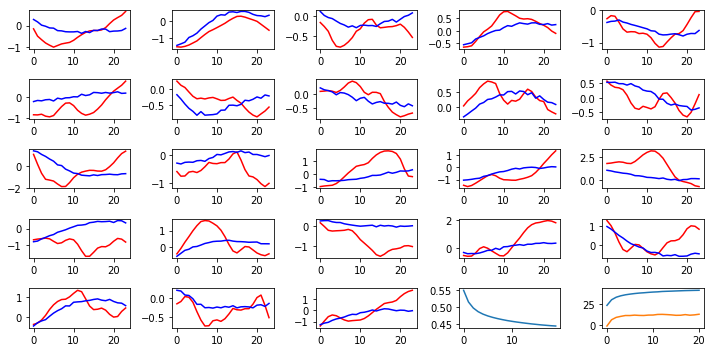

Step: 0, Train Loss: 0.47608351707458496
Step: 50, Train Loss: 0.44111084938049316
Step: 100, Train Loss: 0.4951038360595703
Step: 150, Train Loss: 0.45246320962905884
Step: 200, Train Loss: 0.4869499206542969
Step: 250, Train Loss: 0.44916650652885437
Step: 300, Train Loss: 0.409588098526001
Step: 350, Train Loss: 0.4786795973777771
Step: 400, Train Loss: 0.42281574010849
Epoch: 22, Train loss: 0.44268647358880786
acskill_socre:57.29678808972912, rmse_score:15.54307505464099
acskill_socre:29.227273816925518, rmse_score:16.94004161881693
Epoch: 22, Valid Score: 41.753713035088126, Valid Score 2: 12.287232198108587

Model saved successfully


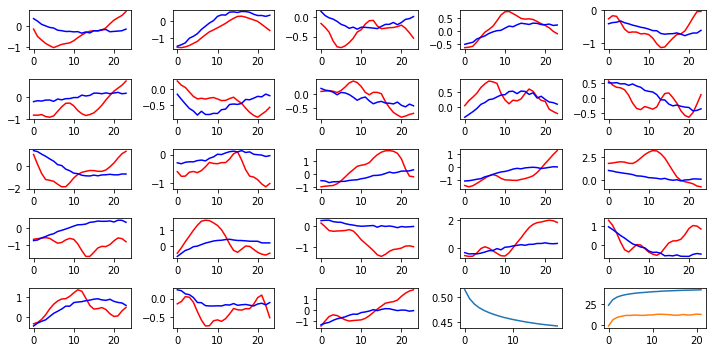

Step: 0, Train Loss: 0.42528200149536133
Step: 50, Train Loss: 0.45606788992881775
Step: 100, Train Loss: 0.4349514842033386
Step: 150, Train Loss: 0.4467436969280243
Step: 200, Train Loss: 0.44421204924583435
Step: 250, Train Loss: 0.41525793075561523
Step: 300, Train Loss: 0.39808937907218933
Step: 350, Train Loss: 0.5215228796005249
Step: 400, Train Loss: 0.44208627939224243
Epoch: 23, Train loss: 0.4417795208393115
acskill_socre:57.31730756775356, rmse_score:15.522384594600144
acskill_socre:29.282855637444932, rmse_score:16.953682983286615
Epoch: 23, Valid Score: 41.79492297315342, Valid Score 2: 12.329172654158317

Model saved successfully


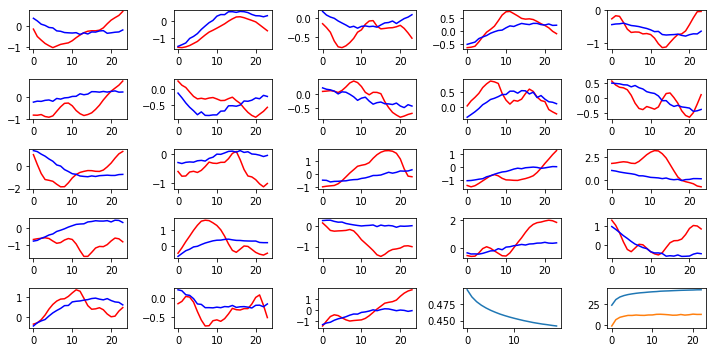

Step: 0, Train Loss: 0.4603949189186096
Step: 50, Train Loss: 0.430527925491333
Step: 100, Train Loss: 0.4653352200984955
Step: 150, Train Loss: 0.4373176693916321
Step: 200, Train Loss: 0.4815629720687866
Step: 250, Train Loss: 0.4241909980773926
Step: 300, Train Loss: 0.4606737494468689
Step: 350, Train Loss: 0.4477347135543823
Step: 400, Train Loss: 0.45638975501060486
Epoch: 24, Train loss: 0.44103644357473365
acskill_socre:57.43392168343718, rmse_score:15.5132988883206
acskill_socre:29.60940866736077, rmse_score:16.898069820822716
Epoch: 24, Valid Score: 41.92062279511658, Valid Score 2: 12.711338846538055

Model saved successfully


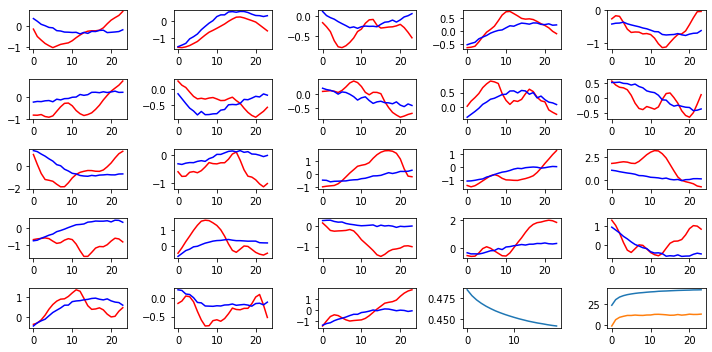

Step: 0, Train Loss: 0.42189908027648926
Step: 50, Train Loss: 0.4438418745994568
Step: 100, Train Loss: 0.4157281517982483
Step: 150, Train Loss: 0.34874027967453003
Step: 200, Train Loss: 0.4633895754814148
Step: 250, Train Loss: 0.43775054812431335
Step: 300, Train Loss: 0.42168694734573364
Step: 350, Train Loss: 0.3821190297603607
Step: 400, Train Loss: 0.38237592577934265
Epoch: 25, Train loss: 0.44021724136237284
acskill_socre:57.55717339620652, rmse_score:15.505180927223686
acskill_socre:29.278229375937435, rmse_score:16.942821613920056
Epoch: 25, Valid Score: 42.05199246898284, Valid Score 2: 12.335407762017379

Model saved successfully


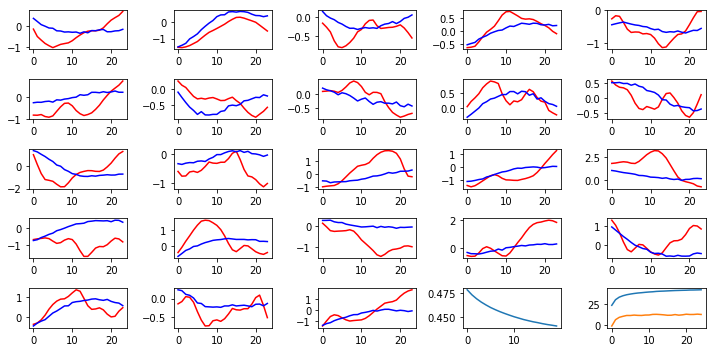

Step: 0, Train Loss: 0.5004802346229553
Step: 50, Train Loss: 0.494795560836792
Step: 100, Train Loss: 0.4861264228820801
Step: 150, Train Loss: 0.40202030539512634
Step: 200, Train Loss: 0.3983936309814453
Step: 250, Train Loss: 0.35138416290283203
Step: 300, Train Loss: 0.39565396308898926
Step: 350, Train Loss: 0.3752176761627197
Step: 400, Train Loss: 0.41153526306152344
Epoch: 26, Train loss: 0.439618664118351
acskill_socre:57.6405201670435, rmse_score:15.488565476019549
acskill_socre:28.898824202882714, rmse_score:16.93808441290119
Epoch: 26, Valid Score: 42.151954691023946, Valid Score 2: 11.960739789981524

Model saved successfully


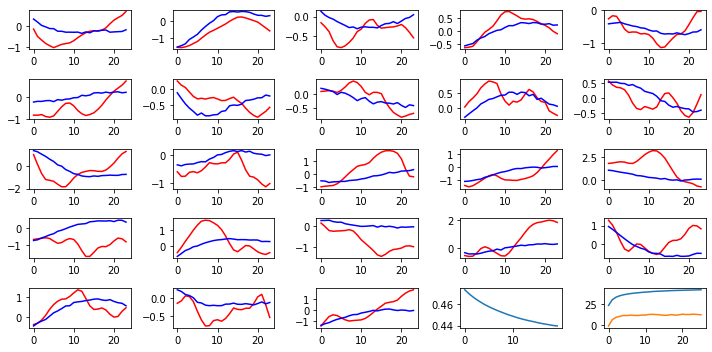

Step: 0, Train Loss: 0.4011140763759613
Step: 50, Train Loss: 0.4630729854106903
Step: 100, Train Loss: 0.4602007269859314
Step: 150, Train Loss: 0.43612825870513916
Step: 200, Train Loss: 0.40775245428085327
Step: 250, Train Loss: 0.4974610209465027
Step: 300, Train Loss: 0.4043619632720947
Step: 350, Train Loss: 0.5219084024429321
Step: 400, Train Loss: 0.4959627091884613
Epoch: 27, Train loss: 0.4388802575556588
acskill_socre:57.66836358215867, rmse_score:15.484155749407467
acskill_socre:29.15285155487529, rmse_score:16.902056044735232
Epoch: 27, Valid Score: 42.1842078327512, Valid Score 2: 12.250795510140058

Model saved successfully


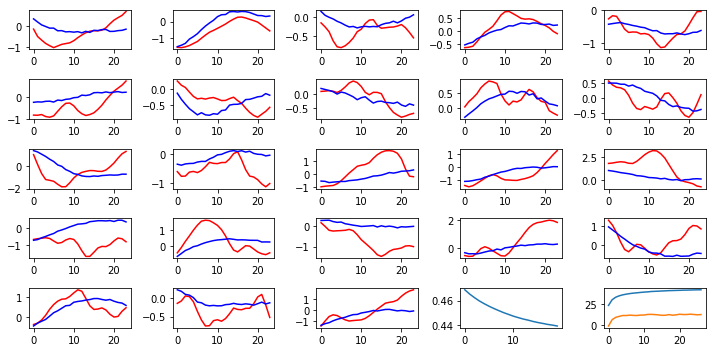

Step: 0, Train Loss: 0.451347291469574
Step: 50, Train Loss: 0.4281122386455536
Step: 100, Train Loss: 0.3791351020336151
Step: 150, Train Loss: 0.47057461738586426
Step: 200, Train Loss: 0.41296836733818054
Step: 250, Train Loss: 0.4700406491756439
Step: 300, Train Loss: 0.4377252757549286
Step: 350, Train Loss: 0.3783907890319824
Step: 400, Train Loss: 0.4838274419307709
Epoch: 28, Train loss: 0.43827416829023313
acskill_socre:57.79576622253635, rmse_score:15.46279051158495
acskill_socre:29.202302400759727, rmse_score:16.928975862538287
Epoch: 28, Valid Score: 42.3329757109514, Valid Score 2: 12.27332653822144

Model saved successfully


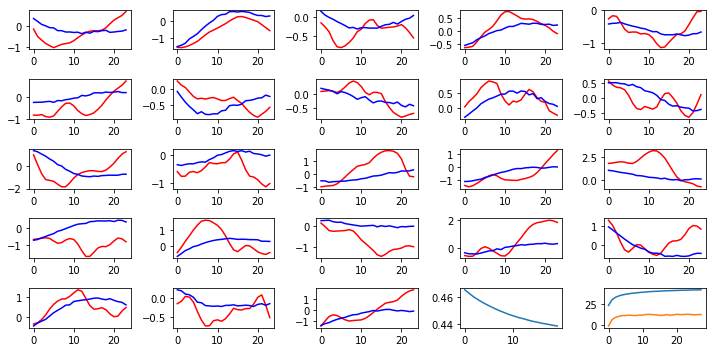

Step: 0, Train Loss: 0.429040789604187
Step: 50, Train Loss: 0.3716784715652466
Step: 100, Train Loss: 0.4678158760070801
Step: 150, Train Loss: 0.4287790060043335
Step: 200, Train Loss: 0.47866639494895935
Step: 250, Train Loss: 0.4771517217159271
Step: 300, Train Loss: 0.46058034896850586
Step: 350, Train Loss: 0.4372881352901459
Step: 400, Train Loss: 0.4636330008506775
Epoch: 29, Train loss: 0.4377216776541624
acskill_socre:57.866445429462615, rmse_score:15.460449017565859
acskill_socre:28.997382925445514, rmse_score:16.91979546003142
Epoch: 29, Valid Score: 42.40599641189676, Valid Score 2: 12.077587465414094

Model saved successfully


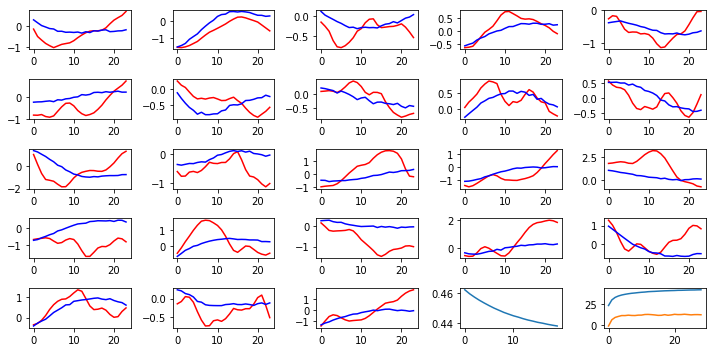

Step: 0, Train Loss: 0.4492609202861786
Step: 50, Train Loss: 0.4097471833229065
Step: 100, Train Loss: 0.4439427852630615
Step: 150, Train Loss: 0.4150499701499939
Step: 200, Train Loss: 0.428178608417511
Step: 250, Train Loss: 0.41407185792922974
Step: 300, Train Loss: 0.3891303539276123
Step: 350, Train Loss: 0.3951300382614136
Step: 400, Train Loss: 0.42273157835006714
Epoch: 30, Train loss: 0.4372931184220653
acskill_socre:57.99163836171795, rmse_score:15.447526759348088
acskill_socre:29.29100246050629, rmse_score:16.964134674476604
Epoch: 30, Valid Score: 42.54411160236987, Valid Score 2: 12.326867786029688

Model saved successfully


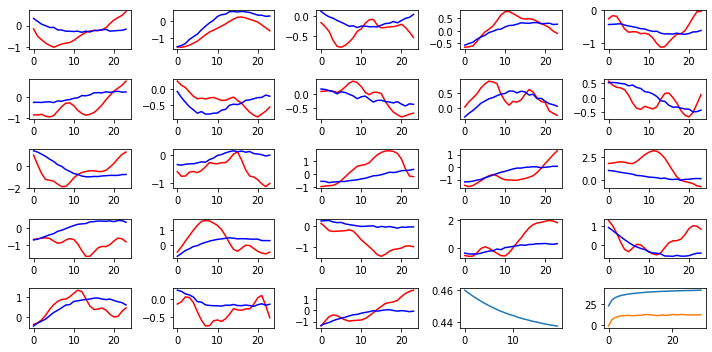

Step: 0, Train Loss: 0.4874173104763031
Step: 50, Train Loss: 0.4237852692604065
Step: 100, Train Loss: 0.3989580571651459
Step: 150, Train Loss: 0.5166789889335632
Step: 200, Train Loss: 0.4804222583770752
Step: 250, Train Loss: 0.44910120964050293
Step: 300, Train Loss: 0.45632117986679077
Step: 350, Train Loss: 0.3906441628932953
Step: 400, Train Loss: 0.4710855484008789
Epoch: 31, Train loss: 0.43672463686262825
acskill_socre:57.92130307803362, rmse_score:15.448034261295735
acskill_socre:29.594938155184614, rmse_score:16.869347684177093
Epoch: 31, Valid Score: 42.473268816737885, Valid Score 2: 12.725590471007521



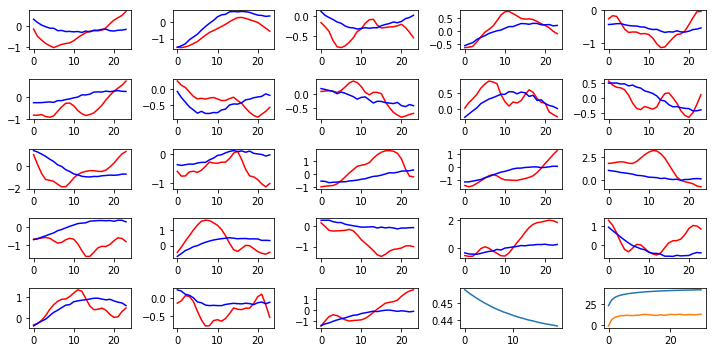

Step: 0, Train Loss: 0.4522096514701843
Step: 50, Train Loss: 0.4456615447998047
Step: 100, Train Loss: 0.3822466731071472
Step: 150, Train Loss: 0.41650980710983276
Step: 200, Train Loss: 0.4123675227165222
Step: 250, Train Loss: 0.41141003370285034
Step: 300, Train Loss: 0.343299001455307
Step: 350, Train Loss: 0.42973217368125916
Step: 400, Train Loss: 0.47587475180625916
Epoch: 32, Train loss: 0.43631852923128844
acskill_socre:57.96509885904737, rmse_score:15.439584280006164
acskill_socre:29.576246704610586, rmse_score:16.871307467872647
Epoch: 32, Valid Score: 42.52551457904121, Valid Score 2: 12.704939236737939



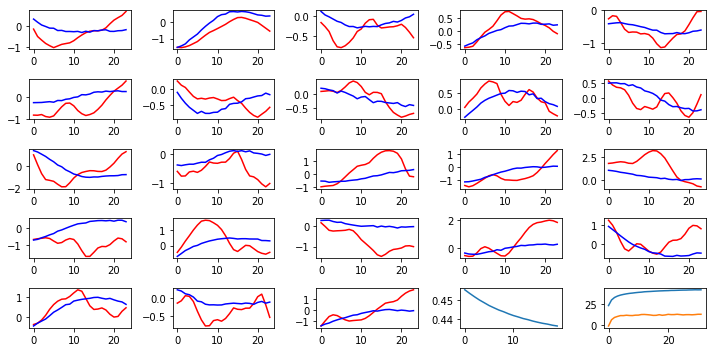

Step: 0, Train Loss: 0.4141518473625183
Step: 50, Train Loss: 0.4592903256416321
Step: 100, Train Loss: 0.37162694334983826
Step: 150, Train Loss: 0.4304061532020569
Step: 200, Train Loss: 0.48693323135375977
Step: 250, Train Loss: 0.3911563754081726
Step: 300, Train Loss: 0.4247991442680359
Step: 350, Train Loss: 0.4697374701499939
Step: 400, Train Loss: 0.4760441184043884
Epoch: 33, Train loss: 0.43580281218928746
acskill_socre:57.90731696835406, rmse_score:15.44232443576427
acskill_socre:29.85893670009034, rmse_score:16.845449661196287
Epoch: 33, Valid Score: 42.46499253258979, Valid Score 2: 13.013487038894052



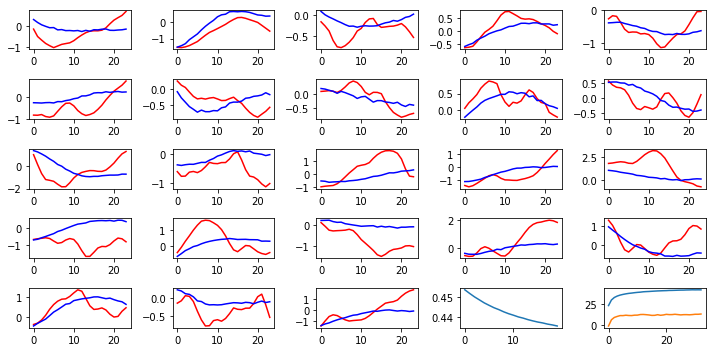

Step: 0, Train Loss: 0.39098501205444336
Step: 50, Train Loss: 0.42645010352134705
Step: 100, Train Loss: 0.38812050223350525
Step: 150, Train Loss: 0.4336121082305908
Step: 200, Train Loss: 0.39594000577926636
Step: 250, Train Loss: 0.3555155396461487
Step: 300, Train Loss: 0.3914654850959778
Step: 350, Train Loss: 0.425873339176178
Step: 400, Train Loss: 0.3975542485713959
Epoch: 34, Train loss: 0.43540695309638977
acskill_socre:58.03149104640376, rmse_score:15.42456035469363
acskill_socre:29.766329068044772, rmse_score:16.887322963109884
Epoch: 34, Valid Score: 42.606930691710126, Valid Score 2: 12.879006104934888

Model saved successfully


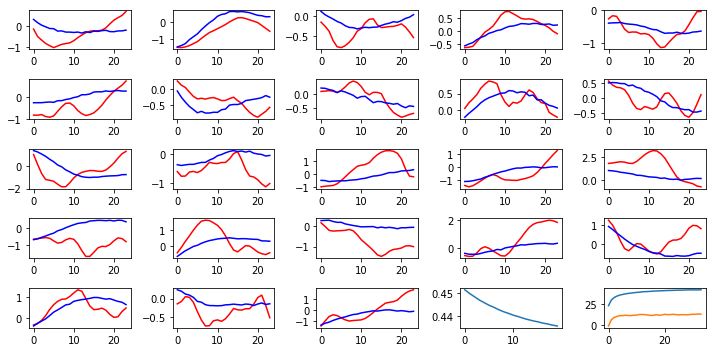

Step: 0, Train Loss: 0.40575581789016724
Step: 50, Train Loss: 0.4312168061733246
Step: 100, Train Loss: 0.3576715588569641
Step: 150, Train Loss: 0.44390198588371277
Step: 200, Train Loss: 0.5133129954338074
Step: 250, Train Loss: 0.4762105345726013
Step: 300, Train Loss: 0.42855069041252136
Step: 350, Train Loss: 0.43008947372436523
Step: 400, Train Loss: 0.3522792458534241
Epoch: 35, Train loss: 0.43510443501845353
acskill_socre:58.11385371955697, rmse_score:15.4174789941807
acskill_socre:30.055386413786415, rmse_score:16.845297523113263
Epoch: 35, Valid Score: 42.69637472537627, Valid Score 2: 13.210088890673152

Model saved successfully


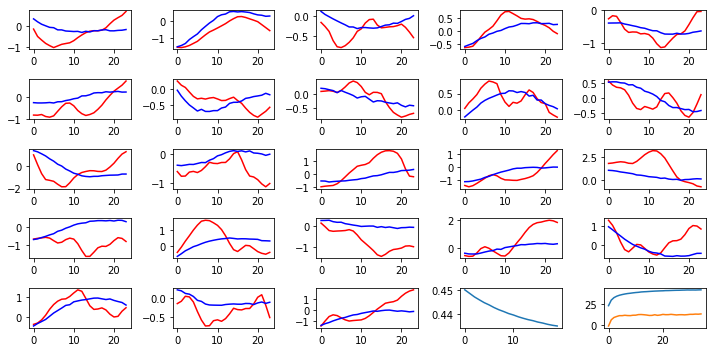

Step: 0, Train Loss: 0.4570710062980652
Step: 50, Train Loss: 0.42542195320129395
Step: 100, Train Loss: 0.4635307490825653
Step: 150, Train Loss: 0.5162069201469421
Step: 200, Train Loss: 0.4484768807888031
Step: 250, Train Loss: 0.5287387371063232
Step: 300, Train Loss: 0.4624854028224945
Step: 350, Train Loss: 0.44963353872299194
Step: 400, Train Loss: 0.395430326461792
Epoch: 36, Train loss: 0.43467430572656657
acskill_socre:58.09925460377631, rmse_score:15.417283353667404
acskill_socre:30.307673864496554, rmse_score:16.822269466005054
Epoch: 36, Valid Score: 42.6819712501089, Valid Score 2: 13.4854043984915



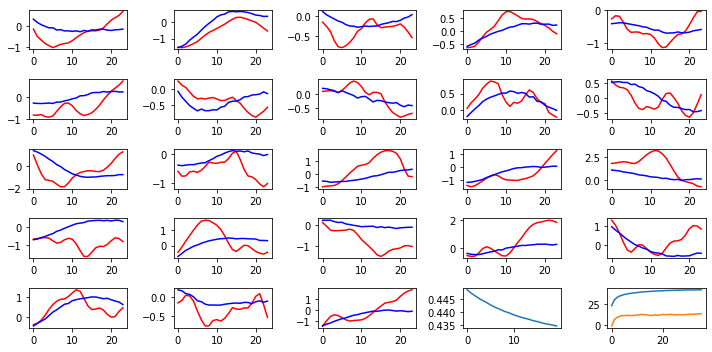

Step: 0, Train Loss: 0.45796912908554077
Step: 50, Train Loss: 0.40115219354629517
Step: 100, Train Loss: 0.4587869644165039
Step: 150, Train Loss: 0.4571588933467865
Step: 200, Train Loss: 0.4003109335899353
Step: 250, Train Loss: 0.47866496443748474
Step: 300, Train Loss: 0.3849191665649414
Step: 350, Train Loss: 0.552024245262146
Step: 400, Train Loss: 0.39444684982299805
Epoch: 37, Train loss: 0.4343430567974163
acskill_socre:58.120483005057885, rmse_score:15.415123138717215
acskill_socre:29.842910576695438, rmse_score:16.885009949662027
Epoch: 37, Valid Score: 42.70535986634067, Valid Score 2: 12.95790062703341

Model saved successfully


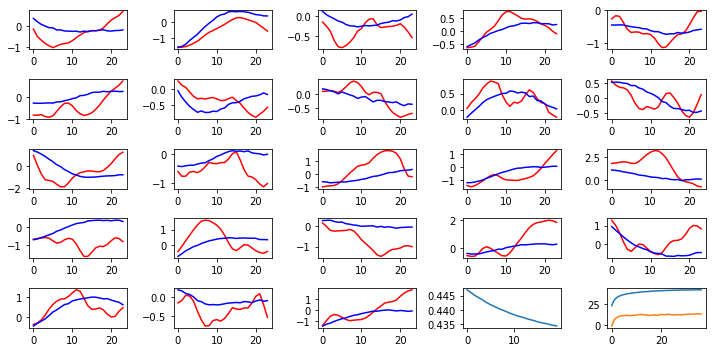

Step: 0, Train Loss: 0.41165420413017273
Step: 50, Train Loss: 0.44571933150291443
Step: 100, Train Loss: 0.4509011209011078
Step: 150, Train Loss: 0.3955432176589966
Step: 200, Train Loss: 0.4965464472770691
Step: 250, Train Loss: 0.49805209040641785
Step: 300, Train Loss: 0.4411252439022064
Step: 350, Train Loss: 0.3598570227622986
Step: 400, Train Loss: 0.48715049028396606
Epoch: 38, Train loss: 0.43396615162844904
acskill_socre:58.22145804844884, rmse_score:15.398357123307576
acskill_socre:30.44203450905836, rmse_score:16.82221706897587
Epoch: 38, Valid Score: 42.82310092514126, Valid Score 2: 13.619817440082489

Model saved successfully


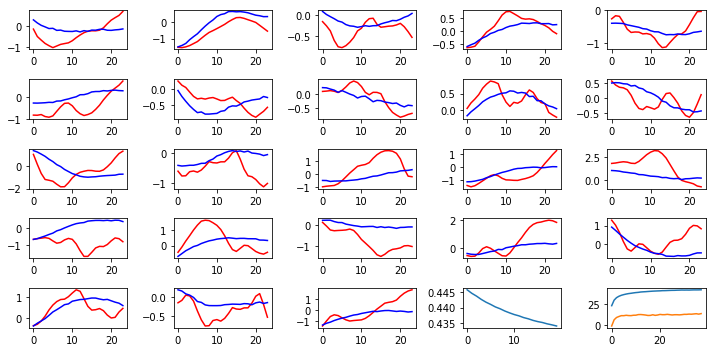

Step: 0, Train Loss: 0.4402192533016205
Step: 50, Train Loss: 0.4039662778377533
Step: 100, Train Loss: 0.41401538252830505
Step: 150, Train Loss: 0.437572717666626
Step: 200, Train Loss: 0.42506879568099976
Step: 250, Train Loss: 0.37230849266052246
Step: 300, Train Loss: 0.42195630073547363
Step: 350, Train Loss: 0.41248369216918945
Step: 400, Train Loss: 0.45392927527427673
Epoch: 39, Train loss: 0.4337670259283617
acskill_socre:58.27618331709766, rmse_score:15.393307178272892
acskill_socre:31.34293902405952, rmse_score:16.754135637804655
Epoch: 39, Valid Score: 42.88287613882477, Valid Score 2: 14.588803386254863

Model saved successfully


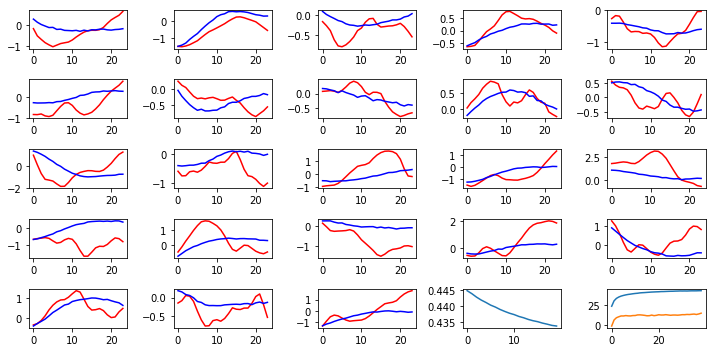

Step: 0, Train Loss: 0.3637242019176483
Step: 50, Train Loss: 0.3584361970424652
Step: 100, Train Loss: 0.3642733693122864
Step: 150, Train Loss: 0.48358115553855896
Step: 200, Train Loss: 0.43414002656936646
Step: 250, Train Loss: 0.4923989772796631
Step: 300, Train Loss: 0.38700002431869507
Step: 350, Train Loss: 0.37130850553512573
Step: 400, Train Loss: 0.41330260038375854
Epoch: 40, Train loss: 0.43353893900934554
acskill_socre:58.31739679790758, rmse_score:15.386005213253025
acskill_socre:30.05943771571527, rmse_score:16.862454764636897
Epoch: 40, Valid Score: 42.93139158465455, Valid Score 2: 13.196982951078372

Model saved successfully


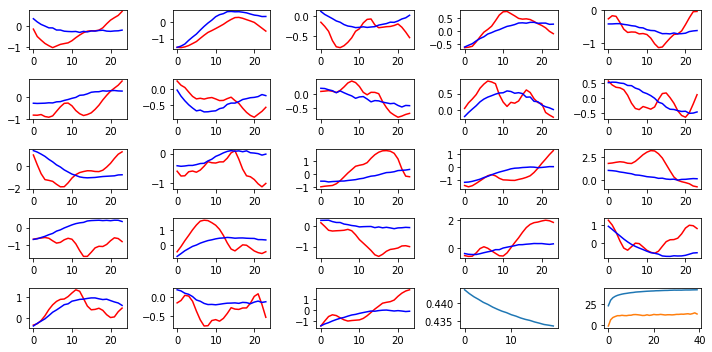

Step: 0, Train Loss: 0.4258652627468109
Step: 50, Train Loss: 0.4339230954647064
Step: 100, Train Loss: 0.43748903274536133
Step: 150, Train Loss: 0.3812274932861328
Step: 200, Train Loss: 0.4113175868988037
Step: 250, Train Loss: 0.39156389236450195
Step: 300, Train Loss: 0.48995932936668396
Step: 350, Train Loss: 0.3844023644924164
Step: 400, Train Loss: 0.4336044192314148
Epoch: 41, Train loss: 0.4330967833504293
acskill_socre:58.34502559020534, rmse_score:15.376792530484293
acskill_socre:30.964098196203352, rmse_score:16.84084502571822
Epoch: 41, Valid Score: 42.968233059721044, Valid Score 2: 14.123253170485132

Model saved successfully


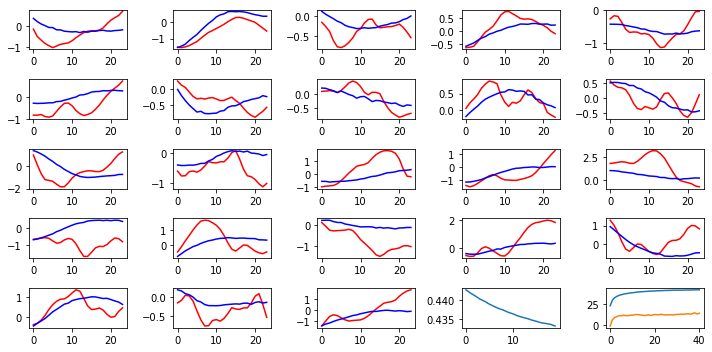

Step: 0, Train Loss: 0.3978022038936615
Step: 50, Train Loss: 0.518431544303894
Step: 100, Train Loss: 0.5218621492385864
Step: 150, Train Loss: 0.532321572303772
Step: 200, Train Loss: 0.5140374898910522
Step: 250, Train Loss: 0.4788553714752197
Step: 300, Train Loss: 0.471299409866333
Step: 350, Train Loss: 0.45934492349624634
Step: 400, Train Loss: 0.40672582387924194
Epoch: 42, Train loss: 0.43291949759727405
acskill_socre:58.288828939775755, rmse_score:15.383138785865999
acskill_socre:31.158577299643554, rmse_score:16.747771588156457
Epoch: 42, Valid Score: 42.90569015390976, Valid Score 2: 14.410805711487097



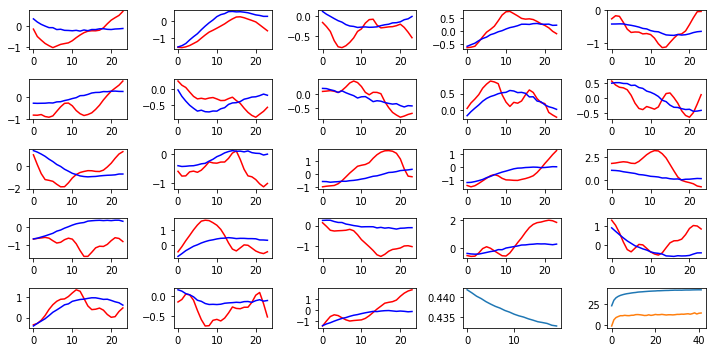

Step: 0, Train Loss: 0.3844072222709656
Step: 50, Train Loss: 0.46326273679733276
Step: 100, Train Loss: 0.4415862560272217
Step: 150, Train Loss: 0.37351056933403015
Step: 200, Train Loss: 0.4031791687011719
Step: 250, Train Loss: 0.44301414489746094
Step: 300, Train Loss: 0.42157381772994995
Step: 350, Train Loss: 0.4806064963340759
Step: 400, Train Loss: 0.502082347869873
Epoch: 43, Train loss: 0.43257442858264344
acskill_socre:58.35173573882349, rmse_score:15.378538238330558
acskill_socre:31.157147677366325, rmse_score:16.75173043567251
Epoch: 43, Valid Score: 42.97319750049294, Valid Score 2: 14.405417241693815

Model saved successfully


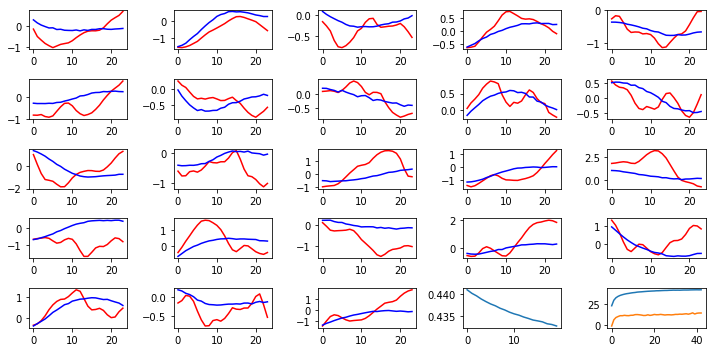

Step: 0, Train Loss: 0.48788368701934814
Step: 50, Train Loss: 0.46809130907058716
Step: 100, Train Loss: 0.4084436297416687
Step: 150, Train Loss: 0.3822423815727234
Step: 200, Train Loss: 0.4427109360694885
Step: 250, Train Loss: 0.3969135284423828
Step: 300, Train Loss: 0.5072242021560669
Step: 350, Train Loss: 0.4293355345726013
Step: 400, Train Loss: 0.45935750007629395
Epoch: 44, Train loss: 0.43224378177339995
acskill_socre:58.42201540149601, rmse_score:15.368216772446905
acskill_socre:30.752363403879578, rmse_score:16.80451149499903
Epoch: 44, Valid Score: 43.053798629049105, Valid Score 2: 13.947851908880548

Model saved successfully


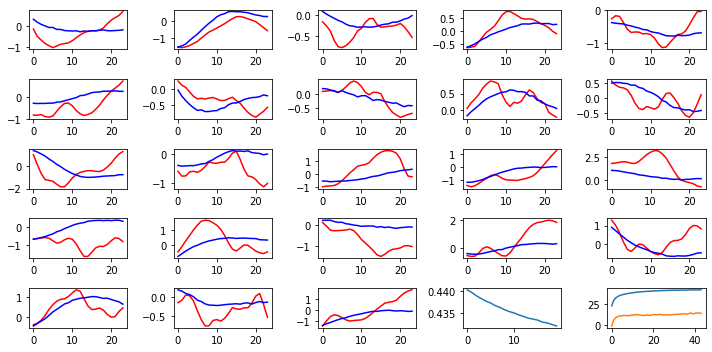

Step: 0, Train Loss: 0.4397997260093689
Step: 50, Train Loss: 0.49978208541870117
Step: 100, Train Loss: 0.4234484136104584
Step: 150, Train Loss: 0.3283156752586365
Step: 200, Train Loss: 0.4413796365261078
Step: 250, Train Loss: 0.38326355814933777
Step: 300, Train Loss: 0.3855564296245575
Step: 350, Train Loss: 0.42029592394828796
Step: 400, Train Loss: 0.4168969988822937
Epoch: 45, Train loss: 0.4321391641811172
acskill_socre:58.40281621568989, rmse_score:15.368574945693336
acskill_socre:30.93352848484634, rmse_score:16.77727168224531
Epoch: 45, Valid Score: 43.034241269996556, Valid Score 2: 14.156256802601032



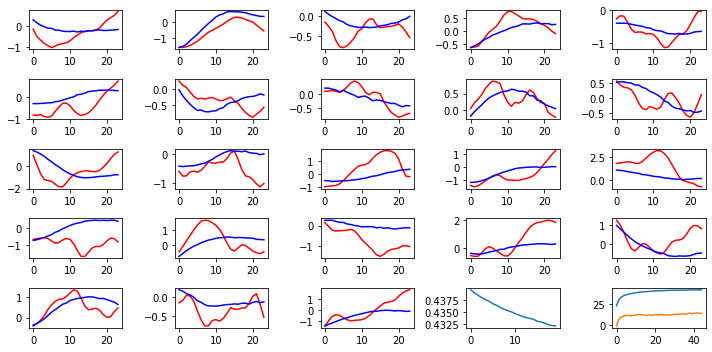

Step: 0, Train Loss: 0.4420403838157654
Step: 50, Train Loss: 0.3688601851463318
Step: 100, Train Loss: 0.38451331853866577
Step: 150, Train Loss: 0.4117220640182495
Step: 200, Train Loss: 0.4106353223323822
Step: 250, Train Loss: 0.41813498735427856
Step: 300, Train Loss: 0.46640801429748535
Step: 350, Train Loss: 0.416003555059433
Step: 400, Train Loss: 0.4294404983520508
Epoch: 46, Train loss: 0.431896957458478
acskill_socre:58.47023168056757, rmse_score:15.359528475046721
acskill_socre:31.054491321326655, rmse_score:16.77651367823279
Epoch: 46, Valid Score: 43.11070320552085, Valid Score 2: 14.277977643093866

Model saved successfully


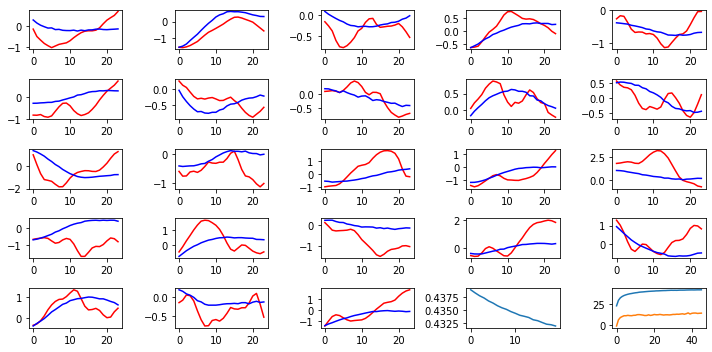

Step: 0, Train Loss: 0.42092832922935486
Step: 50, Train Loss: 0.4338521361351013
Step: 100, Train Loss: 0.4063591957092285
Step: 150, Train Loss: 0.4834378659725189
Step: 200, Train Loss: 0.41829824447631836
Step: 250, Train Loss: 0.3861754834651947
Step: 300, Train Loss: 0.3898088335990906
Step: 350, Train Loss: 0.473726749420166
Step: 400, Train Loss: 0.4117761552333832
Epoch: 47, Train loss: 0.4315636233554632
acskill_socre:58.4620516233174, rmse_score:15.36261078767364
acskill_socre:31.24479527004383, rmse_score:16.77597857563366
Epoch: 47, Valid Score: 43.09944083564376, Valid Score 2: 14.468816694410172



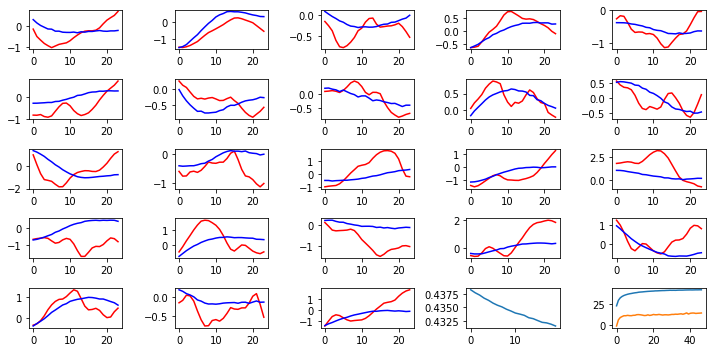

Step: 0, Train Loss: 0.4494307041168213
Step: 50, Train Loss: 0.44031962752342224
Step: 100, Train Loss: 0.39398011565208435
Step: 150, Train Loss: 0.4420135021209717
Step: 200, Train Loss: 0.4020674228668213
Step: 250, Train Loss: 0.4535771608352661
Step: 300, Train Loss: 0.47039997577667236
Step: 350, Train Loss: 0.43404263257980347
Step: 400, Train Loss: 0.4327356815338135
Epoch: 48, Train loss: 0.4314356357282937
acskill_socre:58.551524231755714, rmse_score:15.358866430224387
acskill_socre:31.229849061353804, rmse_score:16.764927177481646
Epoch: 48, Valid Score: 43.192657801531325, Valid Score 2: 14.464921883872158

Model saved successfully


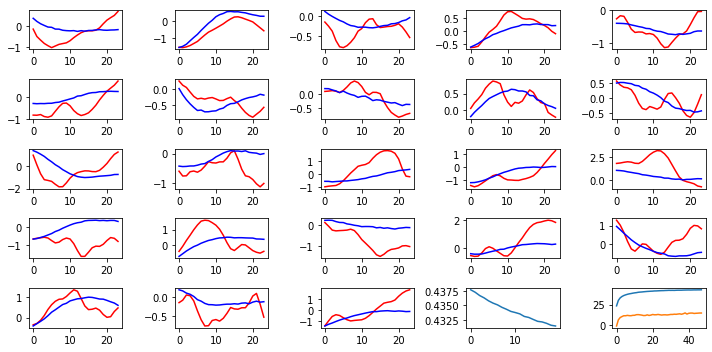

Step: 0, Train Loss: 0.46896904706954956
Step: 50, Train Loss: 0.4590528607368469
Step: 100, Train Loss: 0.4085070788860321
Step: 150, Train Loss: 0.42833375930786133
Step: 200, Train Loss: 0.41698774695396423
Step: 250, Train Loss: 0.37586459517478943
Step: 300, Train Loss: 0.38929125666618347
Step: 350, Train Loss: 0.41345906257629395
Step: 400, Train Loss: 0.43851369619369507
Epoch: 49, Train loss: 0.4311338661688764
acskill_socre:58.528353330779225, rmse_score:15.365058007568114
acskill_socre:31.047297141336987, rmse_score:16.745731150865684
Epoch: 49, Valid Score: 43.16329532321111, Valid Score 2: 14.301565990471303



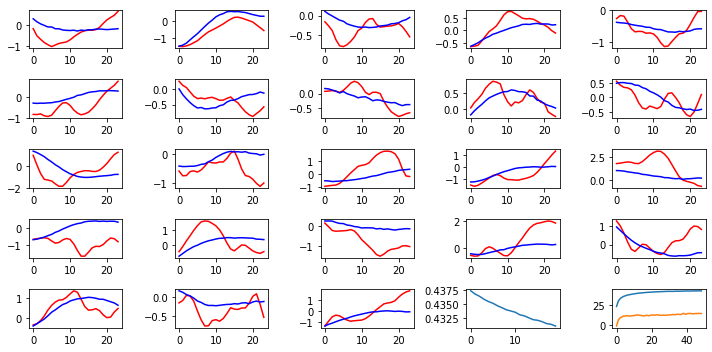

Step: 0, Train Loss: 0.4759708344936371
Step: 50, Train Loss: 0.4221886992454529
Step: 100, Train Loss: 0.39128798246383667
Step: 150, Train Loss: 0.4363672137260437
Step: 200, Train Loss: 0.4726608991622925
Step: 250, Train Loss: 0.4490492045879364
Step: 300, Train Loss: 0.48710107803344727
Step: 350, Train Loss: 0.41351959109306335
Step: 400, Train Loss: 0.4094855785369873
Epoch: 50, Train loss: 0.4309576056297357
acskill_socre:58.515525556134634, rmse_score:15.358034356100028
acskill_socre:31.764286770436307, rmse_score:16.680575558592576
Epoch: 50, Valid Score: 43.157491200034606, Valid Score 2: 15.083711211843731



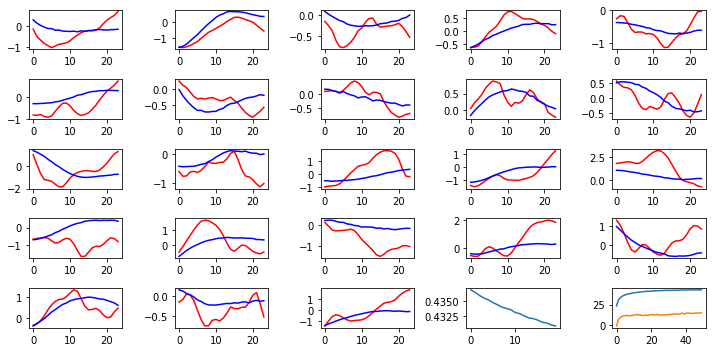

max score: 43.192657801531325 at eopch 48
max score 2: 15.083711211843731 at eopch 50


In [23]:
train(num_epochs=50)

In [16]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [17]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [18]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
#     data_list = [SST,T300,Ua,Va]
#     SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [19]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [20]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [21]:
make_zip()